### Create AprilTag with random size, shape, and noise

In [1]:
import random
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
from create_img_with_tag import ImageSynthesizer

Create one synthetic image with a tag

sample


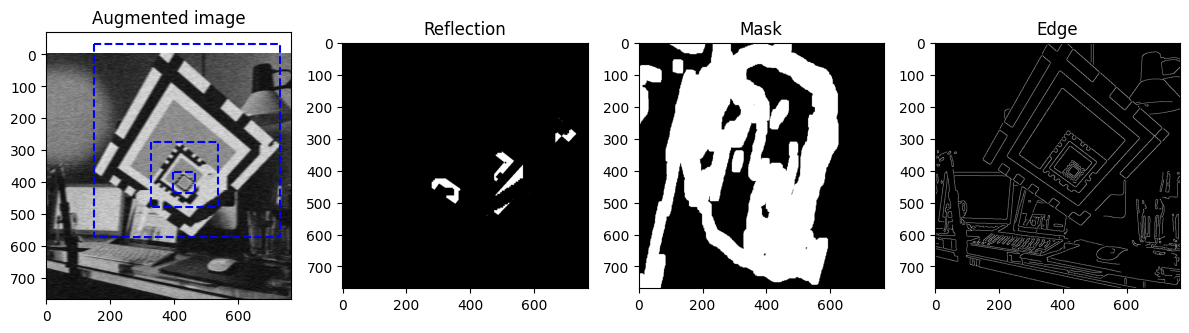

True

In [ ]:
# Load configurations
config_path = 'config_img_with_tag.json'
with open(config_path, 'r') as file:
    data = json.load(file)

scales = data['scales'] # scales of the tags 
margins = data['margins'] # pixel size of tag margine from left top of the empty space
focal_length = data['focal_length']
ratio = data['ratio']
roll = data['roll']
pitch = data['pitch']
yaw = data['yaw']
radius = data['light_radius']
intensity = data['light_intensity']
ksize = random.choice([i for i in range(1, data['ksize']+1, 2)])
sigX = data['sigX']
mean = data['g_noise_mean']
sigma = random.randint(0, data['g_noise_sigma'])
motion_blur_size = random.randint(0, data['motion_blur_size'])
reflection = data['reflection']
train_mode = data['train_mode']
canny_sigma = data['canny_sigma']

imgpath = '../dataset/raw_imgs/test/00a36f96e31731c4.jpg'

mask_src_dir = '../dataset/raw_imgs/mask'
all_masks = os.listdir(mask_src_dir)
mask_filename = random.choice(all_masks)
mask_src_file_path = os.path.join(mask_src_dir, mask_filename)
mask_src = cv2.imread(mask_src_file_path, cv2.IMREAD_GRAYSCALE)

ImgSyn = ImageSynthesizer(imgpath, scales, margins, focal_length, ratio, roll, pitch, yaw, radius, intensity, ksize, sigX, mean, sigma, motion_blur_size, reflection, train_mode, canny_sigma, mask_src)
img_with_tag, homography_matrix, transformed_corners, corner_dict, percent, reflection_img, img_before_reflection, mask, edge = ImgSyn.create_tag()

cv2.imwrite('before_augmentation.jpg', img_with_tag)
aug1_prob = 0.5
if random.random() <= aug1_prob:
    aug1 = ImgSyn.apply_spot_light_effect(img_with_tag)
    aug1_no = ImgSyn.apply_spot_light_effect(img_before_reflection)
else:
    aug1 = img_with_tag
    aug1_no = img_before_reflection

aug2_prob = 0.5
if random.random() <= aug2_prob:
    aug2 = ImgSyn.add_gaussian_blur(aug1)
    aug2_no = ImgSyn.add_gaussian_blur(aug1_no)
else:
    aug2 = aug1
    aug2_no = aug1_no

aug3_prob = 0.5
if random.random() <= aug3_prob:
    aug3 = ImgSyn.add_gaussian_noise(aug2)
    aug3_no = ImgSyn.add_gaussian_noise(aug2_no)
    print('sample')
else:
    aug3 = aug2
    aug3_no = aug2_no

aug4_prob = 1
if random.random() <= aug4_prob:
    aug4 = ImgSyn.apply_motion_blur(aug3)
    aug4_no = ImgSyn.apply_motion_blur(aug3_no)
else:
    aug4 = aug3
    aug4_no = aug3_no
# aug4 = img_with_tag

label = "label.json"
img_size = np.array([aug4.shape[0], aug4.shape[1]])
markers = []
for id, corners in corner_dict.items():
    corners_reshaped = corners.reshape(-1, 2)
    bbox_corners = ImgSyn.bounding_box(corners_reshaped)
    inner_corners = ImgSyn.extract_inner_corners(corners)
    marker = {
    "image_size": img_size.tolist(),
    "corners_outer": corners.tolist(),
    "corners_inner": inner_corners.tolist(),
    "bbox_corners": bbox_corners.tolist(),
    "tag_id": id,
    "reflection_area": percent}
    # if ImgSyn.is_bbox_large(bbox_corners, 50):
    markers.append(marker)

with open(label, 'w') as json_file:
    json.dump(markers, json_file, indent=4)

cv2.imwrite('after_augmentation.jpg', aug4)
plt.figure(figsize=(12, 5))

plt.subplot(1, 4, 1)
plt.imshow(aug4, cmap='gray')                                                                                                                                                       
# plt.plot(*np.append(transformed_corners, [transformed_corners[0]], axis=0).T, 'r-', marker='o', label='Quadrilateral')

for marker in markers:
    plt.plot(*np.append(marker["bbox_corners"], [marker["bbox_corners"][0]], axis=0).T, 'b--', label='Bounding Box')
plt.title('Augmented image')

plt.subplot(1, 4, 2)
plt.imshow(reflection_img, cmap='gray')
plt.title('Reflection')

plt.subplot(1, 4, 3)
plt.imshow(mask, cmap='gray')
plt.title('Mask')

plt.subplot(1, 4, 4)
plt.imshow(edge, cmap='gray')
plt.title('Edge')

plt.tight_layout()
plt.show()

edge_8bit = (edge.astype(np.uint8)) * 255
cv2.imwrite('edge.jpg', edge_8bit)

Create multiple synthetic images with tags

In [ ]:
def gen_syn_img(source_dir, mask_src_dir, dest_dir, label_dir, mask_dir, orig_dir, reflection_dir, edge_dir, json_path):
	with open(json_path, 'r') as file:
		data = json.load(file)

	scales = data['scales'] # scales of the tags 
	margins = data['margins'] # pixel size of tag margine from left top of the empty space
	focal_length = data['focal_length']
	ratio = data['ratio']
	roll = data['roll']
	pitch = data['pitch']
	yaw = data['yaw']
	radius = data['light_radius']
	intensity = data['light_intensity']
	ksize = random.choice([i for i in range(1, data['ksize']+1, 2)])
	sigX = data['sigX']
	mean = data['g_noise_mean']
	sigma = random.randint(0, data['g_noise_sigma'])
	motion_blur_size = random.randint(0, data['motion_blur_size'])
	reflection = data['reflection']
	train_mode = data['train_mode']
	canny_sigma = data['canny_sigma']

	if not os.path.exists(dest_dir):
		os.makedirs(dest_dir)
		
	if not os.path.exists(label_dir):
		os.makedirs(label_dir)

	if not os.path.exists(mask_dir):
		os.makedirs(mask_dir)
	
	if not os.path.exists(orig_dir):
		os.makedirs(orig_dir)

	if not os.path.exists(reflection_dir):
		os.makedirs(reflection_dir)

	if not os.path.exists(edge_dir):
		os.makedirs(edge_dir)

	all_masks = os.listdir(mask_src_dir)
	
	for filename in os.listdir(source_dir):
		# Construct full file path
		file_path = os.path.join(source_dir, filename)
		
		if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif')):
			dest_file_path = os.path.join(dest_dir, filename)
			mask_file_path = os.path.join(mask_dir, filename)
			orig_file_path = os.path.join(orig_dir, filename)
			edge_file_path = os.path.join(edge_dir, filename)
			reflection_file_path = os.path.join(reflection_dir, filename)

			# Pick random mask
			mask_filename = random.choice(all_masks)
			mask_src_file_path = os.path.join(mask_src_dir, mask_filename)
			mask_src = cv2.imread(mask_src_file_path, cv2.IMREAD_GRAYSCALE)
			
			if not os.path.exists(dest_file_path): 
				ImgSyn = ImageSynthesizer(file_path, scales, margins, focal_length, ratio, roll, pitch, yaw, radius, intensity, ksize, sigX, mean, sigma, motion_blur_size, reflection, train_mode, canny_sigma, mask_src)
				img_with_tag, homography_matrix, transformed_corners, corner_dict, percent, reflection_img, img_before_reflection, mask, edge = ImgSyn.create_tag()
				bbox_corners =ImgSyn.bounding_box(transformed_corners)

				aug1_prob = 0.5
				if random.random() <= aug1_prob:
					aug1 = ImgSyn.apply_spot_light_effect(img_with_tag)
					aug1_no = ImgSyn.apply_spot_light_effect(img_before_reflection)
				else:
					aug1 = img_with_tag
					aug1_no = img_before_reflection

				aug2_prob = 0.5
				if random.random() <= aug2_prob:
					aug2 = ImgSyn.add_gaussian_blur(aug1)
					aug2_no = ImgSyn.add_gaussian_blur(aug1_no)
				else:
					aug2 = aug1
					aug2_no = aug1_no

				aug3_prob = 0.5
				if random.random() <= aug3_prob:
					aug3 = ImgSyn.add_gaussian_noise(aug2)
					aug3_no = ImgSyn.add_gaussian_noise(aug2_no)
				else:
					aug3 = aug2
					aug3_no = aug2_no

				aug4_prob = 1
				if random.random() <= aug4_prob:
					aug4 = ImgSyn.apply_motion_blur(aug3)
					aug4_no = ImgSyn.apply_motion_blur(aug3_no)
				else:
					aug4 = aug3
					aug4_no = aug3_no
				
				img_size = np.array([aug4.shape[0], aug4.shape[1]])
				markers = []
				for id, corners in corner_dict.items():
					corners_reshaped = corners.reshape(-1, 2)
					bbox_corners = ImgSyn.bounding_box(corners_reshaped)
					inner_corners = ImgSyn.extract_inner_corners(corners)
					marker = {
					"image_size": img_size.tolist(),
					"corners_outer": corners.tolist(),
					"corners_inner": inner_corners.tolist(),
					"bbox_corners": bbox_corners.tolist(),
					"tag_id": id,
					"reflection_area": percent}
					# if ImgSyn.is_bbox_large(bbox_corners, 50):
					markers.append(marker)
				
			
				cv2.imwrite(dest_file_path, aug4)
				cv2.imwrite(reflection_file_path, reflection_img)
				cv2.imwrite(orig_file_path, aug4_no)
				cv2.imwrite(mask_file_path, mask)
				cv2.imwrite(edge_file_path, edge)
				print(f"Converted and saved {filename} to synthesized image.")
				
				label_file = os.path.splitext(filename)[0] + '.json'
				label_file_path = os.path.join(label_dir, label_file)
				with open(label_file_path, 'w') as json_file:
					json.dump(markers, json_file, indent=4)

In [4]:
# Define your source and destination directories
src_directory         = '../dataset/raw_imgs/test'
mask_src_directory    = '../dataset/raw_imgs/mask'
dst_directory         = '../dataset/deeparuco_noreflection/images/test'
label_directory       = '../dataset/deeparuco_noreflection/labels/test'
mask_directory        = '../dataset/deeparuco_noreflection/masks/test'
reflection_directory  = '../dataset/deeparuco_noreflection/reflections/test'
orig_directory        = '../dataset/deeparuco_noreflection/origs/test'
edge_directory        = '../dataset/deeparuco_noreflection/edges/test'

gen_syn_img(src_directory, mask_src_directory, dst_directory, label_directory, mask_directory, orig_directory, reflection_directory, edge_directory, 'config_img_with_tag.json')


[ WARN:0@244.195] global loadsave.cpp:848 imwrite_ Unsupported depth image for selected encoder is fallbacked to CV_8U.


Converted and saved 09c5b4d6bc25788d.jpg to synthesized image.
Converted and saved 2310a9d90806ca38.jpg to synthesized image.
Converted and saved 870b721faf7b475d.jpg to synthesized image.
Converted and saved cee8149e2f125ded.jpg to synthesized image.
Converted and saved 2c79c6e855e43a45.jpg to synthesized image.
Converted and saved 0a7c597abf1e90d4.jpg to synthesized image.
Converted and saved a296fe25ecf3f7a8.jpg to synthesized image.
Converted and saved 33d4f52120682147.jpg to synthesized image.
Converted and saved d7f59a3da7db74ec.jpg to synthesized image.
Converted and saved fdec7849a0a64567.jpg to synthesized image.
Converted and saved 6cb95fd90d7c2bac.jpg to synthesized image.
Converted and saved c1030024bf97809c.jpg to synthesized image.
Converted and saved 46dacd0222cf169b.jpg to synthesized image.
Converted and saved 9e98e26668bd22a5.jpg to synthesized image.
Converted and saved 921b9f015044bdfc.jpg to synthesized image.
Converted and saved d3ecef711821a6dc.jpg to synthesized

/home/suyeonchoi/Infrared_apriltag_detection/gen_syn_img/create_img_with_tag.py:260: RuntimeWarning: divide by zero encountered in scalar divide
  percent = num_white_pixels / num_black_pixels * 100


Converted and saved 4427b53f2c6a7d7d.jpg to synthesized image.
Converted and saved efa85d442d82b1d5.jpg to synthesized image.
Converted and saved 1654c86093ada840.jpg to synthesized image.
Converted and saved 933f3be3023c5e68.jpg to synthesized image.
Converted and saved 969d53d50722a485.jpg to synthesized image.
Converted and saved 9e2c53451ec7bbc0.jpg to synthesized image.
Converted and saved e000dfe76a25d1b2.jpg to synthesized image.
Converted and saved 9e20494f658f6860.jpg to synthesized image.
Converted and saved 91050cbd94f33e90.jpg to synthesized image.
Converted and saved 19822f5f6db7de1f.jpg to synthesized image.
Converted and saved 07430a3e130e9681.jpg to synthesized image.
Converted and saved 2ebe189cf7049839.jpg to synthesized image.
Converted and saved eb0f9fbe76bdc635.jpg to synthesized image.
Converted and saved 7dd9e8efa288e7cd.jpg to synthesized image.
Converted and saved e18f8379d3e272b5.jpg to synthesized image.
Converted and saved 83499e8f67512938.jpg to synthesized

/home/suyeonchoi/Infrared_apriltag_detection/gen_syn_img/create_img_with_tag.py:260: RuntimeWarning: invalid value encountered in scalar divide
  percent = num_white_pixels / num_black_pixels * 100


Converted and saved ebd0c7e8a9463425.jpg to synthesized image.
Converted and saved 9179c65d79619957.jpg to synthesized image.
Converted and saved 2499021935fff88f.jpg to synthesized image.
Converted and saved cfbd0ea8d3acc635.jpg to synthesized image.
Converted and saved 64f2aa5925fdcd1d.jpg to synthesized image.
Converted and saved a7e5d2727af4299d.jpg to synthesized image.
Converted and saved f4cf9dc875ce67d7.jpg to synthesized image.
Converted and saved 86389117eb778754.jpg to synthesized image.
Converted and saved fd3714e6f70b51b6.jpg to synthesized image.
Converted and saved ebd41ffe9bd153b4.jpg to synthesized image.
Converted and saved 2ef2d4a9f2502fed.jpg to synthesized image.
Converted and saved b6a2b7acf6bd781c.jpg to synthesized image.
Converted and saved 1cbf13ac0cb7030d.jpg to synthesized image.
Converted and saved 8deb491ab16fe49b.jpg to synthesized image.
Converted and saved fed5ef790d653fde.jpg to synthesized image.
Converted and saved c4f39f3bd2e64016.jpg to synthesized

In [ ]:
import random
import numpy as np
import cv2
from scipy.spatial.transform import Rotation as R
from skimage.feature import canny

# mask_path = '/home/suyeonchoi/edge-connect/examples/psv/masks/psv_03.png'
im_path   = '/home/suyeonchoi/Downloads/001_im.png'
img = cv2.imread(im_path, cv2.IMREAD_GRAYSCALE)

def create_canny_edge(img):
    return canny(img, sigma=2).astype(np.float64)

edge = create_canny_edge(img)
edge_8bit = (edge.astype(np.uint8)) * 255
cv2.imwrite('edge_ex.jpg', edge)


True